In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


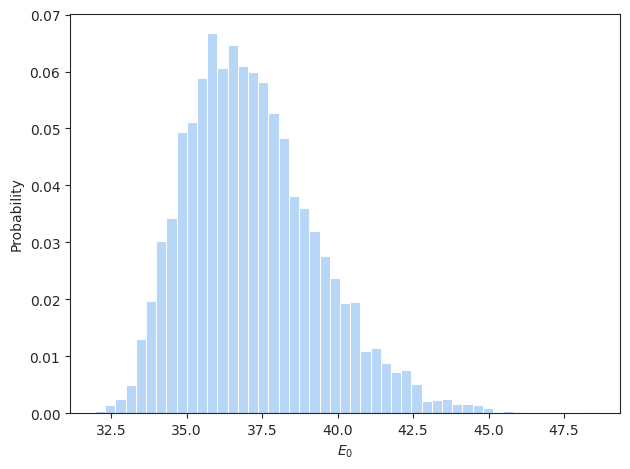

In [6]:
import numpy as np
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('pastel')
sns.set_style('ticks')

from nonlocalgames import methods
from nonlocalgames.hamiltonians import G14

values = []
ham = G14(init_mode='normal')
for i in range(5000):
    ham.init(seed=i)
    w, _ = eigsh(ham.mat, k=1, which='LA')
    values.append(w.item())

sns.histplot(data=values, stat='probability')
plt.xlabel('$E_0$')
plt.tight_layout()
plt.savefig('plots/g14/g14_random_init.png', dpi=300)

In [9]:
import json
import logging
import numpy as np
import pandas as pd
import gymnasium as gym
gym.logger.set_level(logging.CRITICAL)

from nonlocalgames import methods
from nonlocalgames.hamiltonians import G14

best_energy = np.inf
best_energies = None
best_ansatz, best_phi = None, None

records = []

for i in range(50):
    ham = G14()
    energies, state, phi = methods.dual_phase_optim(ham, verbose=1, seed=i, tol=1e-6)
    energy = energies[-1]

    for iter_, e in enumerate(energies):
        records.append({
            'id': i,
            'iter': iter_ + 1,
            'energy': e,
        })
    
    if energy < best_energy:
        best_energy = energy
        best_energies = energies
        state = [(theta, str(gate)) for theta, gate in state]
        best_ansatz = state
        best_phi = phi.reshape(2, 14, 2).tolist()

        with open('data/g14_state.json', 'w', encoding='utf-8') as f:
            json.dump({
                'state': best_ansatz,
                'phi': best_phi,
                'energies': best_energies
            }, f)

df = pd.DataFrame.from_records(records)
df.to_csv('data/g14_trials.csv', index=False)

Iter 1
-----------


KeyboardInterrupt: 

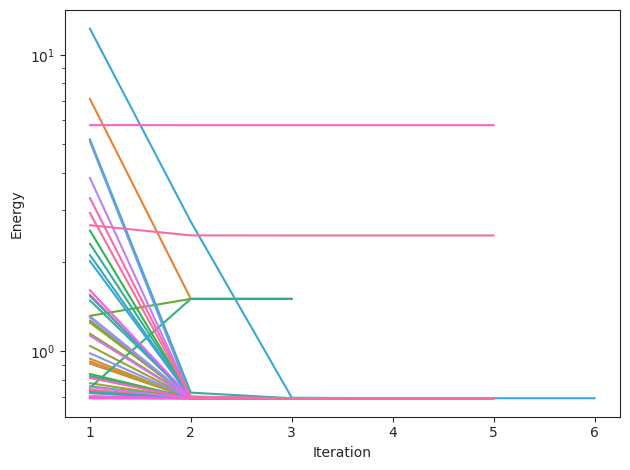

In [11]:
import pandas as pd

df = pd.read_csv('data/g14_trials.csv')
sns.lineplot(data=df, x='iter', y='energy', hue=df.id.astype(str), legend=False)
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.yscale('log')
plt.tight_layout()
plt.savefig('plots/g14_trials.png', dpi=300)

### Test generated circuit

We're going to load the saved ADAPT ansatz and convert it to a Qiskit circuit. Then, we'll use the utility class `NLGCircuit` to evaluate each of the possible referee questions on G14.

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


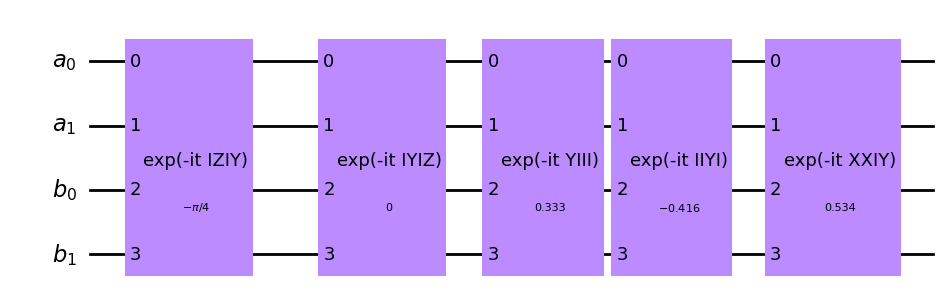

In [15]:
import json
import numpy as np

# Qiskit has deprecated code inside of it
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    from qiskit_aer import AerSimulator

from nonlocalgames.hamiltonians import G14
from nonlocalgames.circuit import NLGCircuit, load_adapt_ansatz

def load_g14_circuit(path: str):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    qubits = 2
    players = 2
    qc = load_adapt_ansatz(
        data['state'],
        [qubits] * players,
        adapt_order=True)

    # Don't need to transform phi since qinfo's Ry gate follows the qiskit convention
    phi = np.array(data['phi'])

    return qc, phi

shared_state, phi = load_g14_circuit('data/g14_state.json')
shared_state.draw('mpl')

Construct the `NLGCircuit` from the ansatz, and draw it to make sure it looks reasonable.

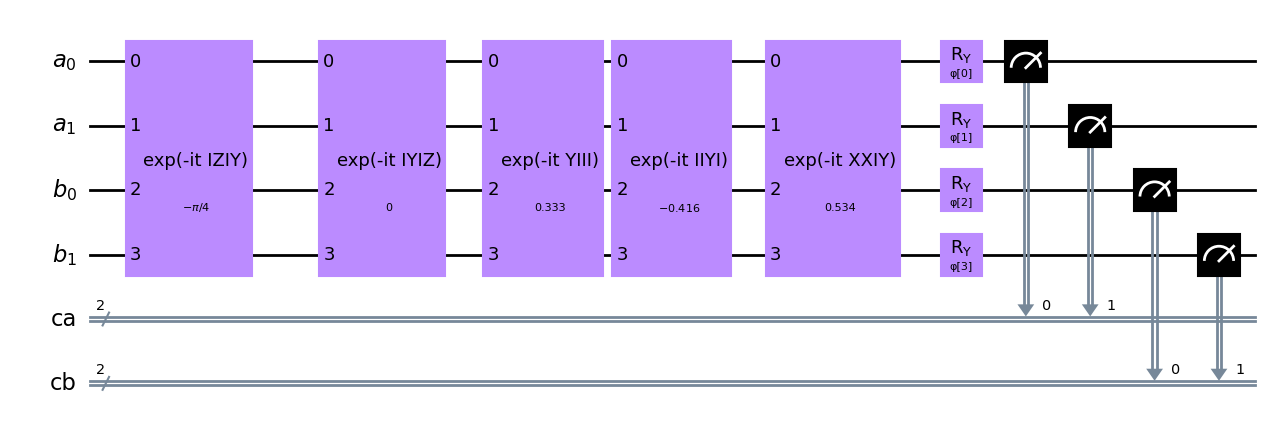

In [16]:
sim = AerSimulator()
nlg = NLGCircuit(shared_state, phi, sim=sim)
nlg.qc.draw('mpl')

Here's a sample response where $v_a = v_b = 1$. The players should respond with the same color $c_a = c_b$ to win.

In [17]:
nlg.ask([1, 1], shots=1024)

{(1, 3): 12,
 (1, 1): 22,
 (1, 0): 98,
 (0, 2): 9,
 (0, 3): 28,
 (1, 2): 174,
 (0, 0): 50,
 (0, 1): 631}

Construct a dataframe consisting of 1024 trials (shots) for each possible question.

In [18]:
import pandas as pd

vertices = [(i, i) for i in range(14)]
edges = G14._get_graph().edge_links.tolist()
questions = vertices + edges
N = 1024

records = []
for va, vb in questions:
    counts = nlg.ask((va, vb), shots=N)
    for (ca, cb), n in counts.items():
        records.append({
            'va': va,
            'vb': vb,
            'ca': ca,
            'cb': cb,
            'n': n
        })

df = pd.DataFrame.from_records(records)
df.to_csv('data/g14_responses.csv', index=False)
df

,va,vb,ca,cb,n
0,0,0,1,3,1
1,0,0,1,1,36
2,0,0,2,3,101
3,0,0,2,0,19
4,0,0,0,0,24
...,...,...,...,...,...
959,12,13,0,2,79
960,12,13,1,2,42
961,12,13,1,1,38
962,12,13,2,1,1


We'd like to calculate the win rate for each question.

In [19]:
def winrate(gdf: pd.DataFrame):
    if np.all(gdf.va == gdf.vb):
        return gdf.loc[gdf.ca == gdf.cb].n.sum() / N
    else:
        return gdf.loc[gdf.ca != gdf.cb].n.sum() / N

wr = df.groupby(['va', 'vb']).apply(winrate).reset_index(name='win_rate')
wr

,va,vb,win_rate
0,0,0,0.060547
1,0,1,0.464844
2,0,2,0.957031
3,0,3,0.962891
4,0,4,0.488281
...,...,...,...
83,13,9,0.310547
84,13,10,0.983398
85,13,11,0.668945
86,13,12,0.873047


In [20]:
wr.to_csv('data/g14_win_rate.csv', index=False)

Plot the win rate per question type (either $v_a = v_b$ or $v_a \sim v_b$).

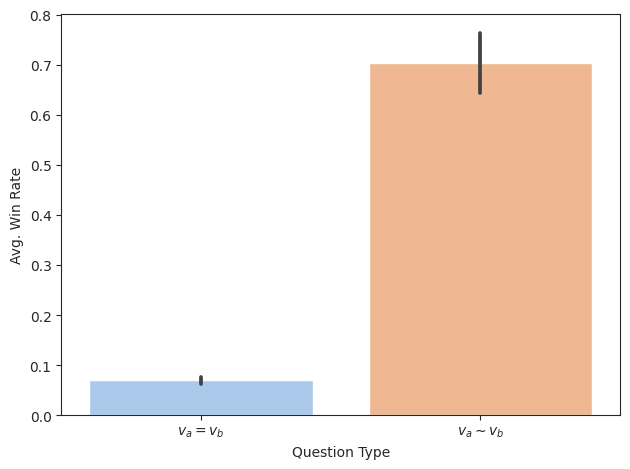

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
sns.set_palette('pastel')

wr['question'] = np.where(wr.va == wr.vb, '$v_a = v_b$', '$v_a \sim v_b$')

sns.barplot(data=wr, x='question', y='win_rate')
plt.xlabel('Question Type')
plt.ylabel('Avg. Win Rate')
plt.tight_layout()
plt.savefig('plots/g14/g14_win_rate.png', dpi=300)
plt.show()

Calculate the balance of the question types. The fact that there's many more edge questions than vertex questions suggests we should re-weight the hamiltonian terms, similar to if we had an imbalanced dataset in a supervised learning problem.

In [24]:
print(wr.question.value_counts())

$v_a \sim v_b$    74
$v_a = v_b$       14
Name: question, dtype: int64
